In [1]:
# Load the environment variables from the .env file
import os
from dotenv import load_dotenv

# Define state variables in the chatbot
from typing import Annotated, Literal
from typing_extensions import TypedDict

# Connect to the RAG database.
from neo4j import GraphDatabase

#Langgraph
from langgraph.graph.message import add_messages

# Chatbot logic
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
# It can be helpful to visualise the graph you just defined. The following code renders the graph.
from IPython.display import Image, display
# Add the human node to the graph.
from langchain_core.messages.ai import AIMessage

# use to create the tool node in the graph
from langchain_core.tools import tool


In [2]:
from typing import List, Optional, Tuple
from pydantic import BaseModel, Field

In [3]:
class ItineraryDetails(BaseModel):
    """State representing the customer's tourist details conversation."""

    # The chat conversation history, updated by appending messages
    messages: List[str] = Field(default_factory=list)

    # The customer's trip details
    trip_details: List[str] = Field(default_factory=list)

    # User's name for personalized interaction
    user_name: Optional[str] = None

    # Type of trip (e.g., "Family Fun" or "Adventure Outdoor")
    trip_type: Optional[str] = None

    # Number of days in the itinerary
    itinerary_days: Optional[int] = None

    # The target city selected by the user
    target_city: Optional[str] = None

    # List of recommended cities
    recommended_cities: List[str] = Field(default_factory=list)

    # The selected hotel/accommodation
    selected_hotel: Optional[str] = None

    # Flag indicating that the itinerary is confirmed and complete
    finished: bool = False

In [4]:
# 🟢 Node 1: Initial Engagement (Collects User Details)
def initial_node(state: ItineraryDetails, user_input: dict) -> Tuple[ItineraryDetails, str]:
    """Collect user's name, trip type, and target city."""
    state.user_name = user_input.get("user_name", state.user_name)
    state.trip_type = user_input.get("trip_type", state.trip_type)
    state.itinerary_days = user_input.get("itinerary_days", state.itinerary_days)
    
    # If no city is specified, suggest one
    if not state.target_city:
        state.recommended_cities = recomendar_ciudades()
        return state, "ask_target_city"
    
    return state, "validate_days"

In [5]:
# 🟠 Node 2: Validate Days
def validate_days_node(state: ItineraryDetails) -> Tuple[ItineraryDetails, str]:
    """Checks if the number of days is greater than 5 and suggests multiple cities if needed."""
    if state.itinerary_days is not None and state.itinerary_days > 5:
        return state, "suggest_multiple_cities"
    return state, "confirm_details"

In [6]:
# 🔵 Node 3: Confirm Details
def confirm_details_node(state: ItineraryDetails, user_input: dict) -> Tuple[ItineraryDetails, str]:
    """Asks the user to confirm their choices before finalizing the itinerary."""
    confirmation = user_input.get("confirmation", False)
    
    if confirmation:
        state.finished = True  # Mark as completed
        return state, "finalize_node"  # Return "finalize_node" instead of "finalize_itinerary"
    
    return state, "reset_node"  # Return "reset_node" instead of "reset"

In [7]:
# 🔄 Node 4: Reset Conversation
def reset_node(state: ItineraryDetails) -> Tuple[ItineraryDetails, str]:
    """Resets the state and restarts the conversation."""
    return ItineraryDetails(), "initial_node"

In [8]:
# Helper function to save the itinerary (pseudo-code)
def save_itinerary(itinerary: ItineraryDetails):
    """
    Saves the itinerary to a database or file.

    Args:
        itinerary (ItineraryDetails): The itinerary details to save.
    """
    # Example: Save to a database (replace with actual implementation)
    # database.save(itinerary)
    print(f"Saving itinerary: {itinerary}")

    # Example: Save to a file
    with open("itinerary.txt", "w") as file:
        file.write(str(itinerary))

In [9]:
def finalize_node(state: ItineraryDetails) -> dict:
    """
    Finalizes the itinerary by saving details, generating a summary, and returning a confirmation message.

    Args:
        state (ItineraryDetails): The current state of the itinerary details.

    Returns:
        dict: A dictionary containing the final confirmation message and any additional data.
    """
    # Example: Generate a summary of the itinerary
    summary = f"""
    Itinerary Summary:
    - Destination: {state.destination}
    - Number of Days: {state.num_days}
    - Activities: {', '.join(state.activities)}
    - Confirmed: {state.is_confirmed}
    """

    # Example: Save the itinerary to a database or file (pseudo-code)
    save_itinerary(state)

    # Example: Notify the user or system that the itinerary is finalized
    confirmation_message = "Your itinerary has been finalized. Thank you for using our service!"

    # Return the result
    return {
        "status": "success",
        "message": confirmation_message,
        "summary": summary,
        "itinerary": state  # Optionally return the state for further use
    }

In [10]:
def should_finalize(state):
    return state.finished 

def transition_to_finalize(state: ItineraryDetails) -> str:
    """
    Determines the next node based on the state.

    Args:
        state (ItineraryDetails): The current state of the itinerary.

    Returns:
        str: The next node to transition to ("finalize_node" or "reset_node").
    """
    if state.finished:  # Use the same condition as confirm_details_node
        return "finalize_node"
    else:
        return "reset_node"

In [11]:
def should_reset(state):
    return not state.finished

def transition_to_reset(state):
    if should_reset(state):
        return "reset" 

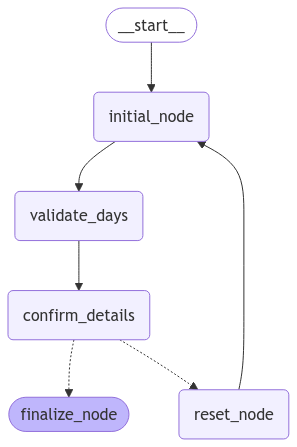

In [13]:
# Initialize the workflow
workflow = StateGraph(ItineraryDetails)

# Add nodes to the workflow
workflow.add_node("initial_node", initial_node)
workflow.add_node("validate_days", validate_days_node)
workflow.add_node("confirm_details", confirm_details_node)
workflow.add_node("finalize_node", finalize_node)  # Ensure this node is added
workflow.add_node("reset_node", reset_node)  # Ensure this node is added

# Define edges
workflow.set_entry_point("initial_node")
workflow.add_edge("initial_node", "validate_days")
workflow.add_edge("validate_days", "confirm_details")

# Add conditional edge from confirm_details
workflow.add_conditional_edges(
    "confirm_details",
    transition_to_finalize,  # Function to determine the next node
    {
        "finalize_node": "finalize_node",  # Transition to finalize_node
        "reset_node": "reset_node"  # Transition to reset_node
    }
)

# Add edge from reset_node back to initial_node
workflow.add_edge("reset_node", "initial_node")

# Compile the workflow
app = workflow.compile()
Image(app.get_graph().draw_mermaid_png())